In [ ]:
#%pip install nbeats-pytorch # runtime restart required

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import re
import numpy as np

#import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from lightgbm import LGBMRegressor

from sklearn.model_selection import TimeSeriesSplit

df_pkl = pd.read_pickle("/content/drive/MyDrive/Master_Thesis/Datasets/visuelle2/Extra_Datasets/dataFinal.pkl")
sales = pd.read_csv("/content/drive/MyDrive/Master_Thesis/Datasets/visuelle2/sales.csv")

In [ ]:
df = df_pkl.sort_index()
display(df.head())

,Unnamed: 0,external_code,retail,season,category,color,image_path,fabric,release_date,restock,...,10,11,category_encoded,color_encoded,fabric_encoded,image_features,cat_gtrend,col_gtrend,fab_gtrend,date_encoded
0,0,5,36,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,22,...,0.0,0.0,11,4,0,2.499182,"[85.0, 84.0, 76.0, 65.0, 61.0, 59.0, 54.0, 53....","[20.0, 18.0, 18.0, 16.0, 18.0, 19.0, 17.0, 18....","[68.0, 69.0, 71.0, 78.0, 72.0, 69.0, 66.0, 69....",0
1,1,2,51,SS17,long sleeve,violet,PE17/00002.png,acrylic,2016-11-28,17,...,1.0,0.0,11,7,0,2.578126,"[85.0, 84.0, 76.0, 65.0, 61.0, 59.0, 54.0, 53....","[56.0, 58.0, 59.0, 54.0, 58.0, 55.0, 58.0, 59....","[68.0, 69.0, 71.0, 78.0, 72.0, 69.0, 66.0, 69....",0
2,2,5,10,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,15,...,0.0,1.0,11,4,0,2.499182,"[85.0, 84.0, 76.0, 65.0, 61.0, 59.0, 54.0, 53....","[20.0, 18.0, 18.0, 16.0, 18.0, 19.0, 17.0, 18....","[68.0, 69.0, 71.0, 78.0, 72.0, 69.0, 66.0, 69....",0
3,3,9,41,SS17,culottes,yellow,PE17/00009.png,scuba crepe,2016-11-28,32,...,0.0,0.0,1,9,49,1.695715,"[46.0, 52.0, 48.0, 47.0, 47.0, 48.0, 35.0, 56....","[72.0, 73.0, 71.0, 74.0, 74.0, 74.0, 75.0, 77....","[0.0, 17.0, 18.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0....",0
4,4,5,13,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,26,...,0.0,0.0,11,4,0,2.499182,"[85.0, 84.0, 76.0, 65.0, 61.0, 59.0, 54.0, 53....","[20.0, 18.0, 18.0, 16.0, 18.0, 19.0, 17.0, 18....","[68.0, 69.0, 71.0, 78.0, 72.0, 69.0, 66.0, 69....",0


# Features Handling

In [ ]:
cols = ['cat_gtrend', 'col_gtrend', 'fab_gtrend']

for col in cols:
    df[col] = df[col].apply(np.mean) # reducing dimension by taking mean

#replace NaN with zeros
df.fillna(0, inplace=True)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


# Split Data

In [ ]:
#split data
x_train = df[['category_encoded', 'fabric_encoded', 'color_encoded', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9','image_features', 'cat_gtrend', 'col_gtrend', 'fab_gtrend','date_encoded']]

y_train = df[['10']]

x_test = df[['category_encoded', 'fabric_encoded', 'color_encoded', '1', '2', '3', '4', '5', '6', '7', '8', '9','10','image_features', 'cat_gtrend', 'col_gtrend', 'fab_gtrend','date_encoded']]

y_test = df[['11']]


x_test_original = x_test.to_numpy()  # saving it for plotting

# Select TimeSeries columns
scale_columns_train = [ '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
scale_columns_test = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

# Convert specific DataFrame columns to a NumPy array
x_train_np = x_train.loc[:,scale_columns_train].to_numpy()
x_test_np = x_test.loc[:,scale_columns_test].to_numpy()


# Standardize the NumPy array
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_np)
x_test_scaled = scaler.transform(x_test_np)

# Replace original DataFrame columns with standardized values
x_train.loc[:,scale_columns_train] = x_train_scaled
x_test.loc[:,scale_columns_test] = x_test_scaled

# Convert entire DataFrame to a NumPy array
x_train = x_train.values
y_train = y_train.values
x_test = x_test.values
y_test = y_test.values

# **NBEATS Model Creation**

In [ ]:
import warnings
from nbeats_pytorch.model import NBeatsNet as NBeatsPytorch

In [ ]:
def createModel():
  model_pytorch = NBeatsPytorch(backcast_length=18, forecast_length=1,
                              stack_types=(NBeatsPytorch.GENERIC_BLOCK, NBeatsPytorch.GENERIC_BLOCK,
                                           NBeatsPytorch.SEASONALITY_BLOCK, NBeatsPytorch.TREND_BLOCK,),
                              nb_blocks_per_stack=2, thetas_dim=(4,4,4,4),
                              share_weights_in_stack=True, hidden_layer_units=64)
  return model_pytorch

In [ ]:
'''
#interpretable
def createModel():
  model_pytorch = NBeatsPytorch(backcast_length=17, forecast_length=1,
                              stack_types=(NBeatsPytorch.SEASONALITY_BLOCK, NBeatsPytorch.TREND_BLOCK,),
                              nb_blocks_per_stack=2, thetas_dim=(4,4),
                              share_weights_in_stack=True, hidden_layer_units=64)
  return model_pytorch
'''

'\n#interpretable\ndef createModel():\n  model_pytorch = NBeatsPytorch(backcast_length=17, forecast_length=1,\n                              stack_types=(NBeatsPytorch.SEASONALITY_BLOCK, NBeatsPytorch.TREND_BLOCK,),\n                              nb_blocks_per_stack=2, thetas_dim=(4,4),\n                              share_weights_in_stack=True, hidden_layer_units=64)\n  return model_pytorch\n'

In [ ]:
'''
# generic Nbeats
def createModel():
    model_pytorch = NBeatsPytorch( backcast_length=17, forecast_length=1,
                                      stack_types=(NBeatsPytorch.GENERIC_BLOCK, NBeatsPytorch.GENERIC_BLOCK),
                                      nb_blocks_per_stack=2, thetas_dim=(4, 4), share_weights_in_stack=True,
                                      hidden_layer_units=64)
    return model_pytorch
'''

'\n# generic Nbeats\ndef createModel():\n    model_pytorch = NBeatsPytorch( backcast_length=17, forecast_length=1,\n                                      stack_types=(NBeatsPytorch.GENERIC_BLOCK, NBeatsPytorch.GENERIC_BLOCK),\n                                      nb_blocks_per_stack=2, thetas_dim=(4, 4), share_weights_in_stack=True,\n                                      hidden_layer_units=64)\n    return model_pytorch\n'

In [ ]:
model_pytorch = createModel()
model_pytorch.compile(loss='mse', optimizer='adam')

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=18, forecast_length=1, share_thetas=False) at @133307044971952
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=18, forecast_length=1, share_thetas=False) at @133307044971952
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=18, forecast_length=1, share_thetas=False) at @133307044977280
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=18, forecast_length=1, share_thetas=False) at @133307044977280
| --  Stack Seasonality (#2) (share_weights_in_stack=True)
     | -- SeasonalityBlock(units=64, thetas_dim=1, backcast_length=18, forecast_length=1, share_thetas=True) at @133307044975744
     | -- SeasonalityBlock(units=64, thetas_dim=1, backcast_length=18, forecast_length=1, share_thetas=True) at @133307044975744
| --  Stack Trend (#3) (share_weights_in_stack=True)
     |

In [ ]:
print('Pytorch training...')
model_pytorch.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=16)

Pytorch training...
Epoch 1/5
6679/6679 [==============================] - 46s 7ms/step - loss: 2.0131 - val_loss: 1.4843
Epoch 2/5
6679/6679 [==============================] - 45s 6ms/step - loss: 1.7117 - val_loss: 1.4782
Epoch 3/5
6679/6679 [==============================] - 44s 6ms/step - loss: 1.6663 - val_loss: 1.4392
Epoch 4/5
6679/6679 [==============================] - 44s 6ms/step - loss: 1.6464 - val_loss: 1.4564
Epoch 5/5
6679/6679 [==============================] - 45s 6ms/step - loss: 1.6297 - val_loss: 1.4559


In [ ]:
y_test_pred = model_pytorch.predict(x_test)


# MAE
model_mae = mae(y_test, y_test_pred)
mae_values = []
mae_values.append({"model":model_mae})
print("Model Validation mode_mae : ", model_mae)

#Weighted Absolute Percent Error
model_wape = ((mae(y_test,y_test_pred)*int(len(y_test_pred)) ) / sum(y_test)[0])*100
print("Model Validation wape : ", model_wape)
wape_values = []
wape_values.append({"model": model_wape})

Model Validation mode_mae :  0.6783207388352437
Model Validation wape :  104.55349087525718


## **Plot Predictions**

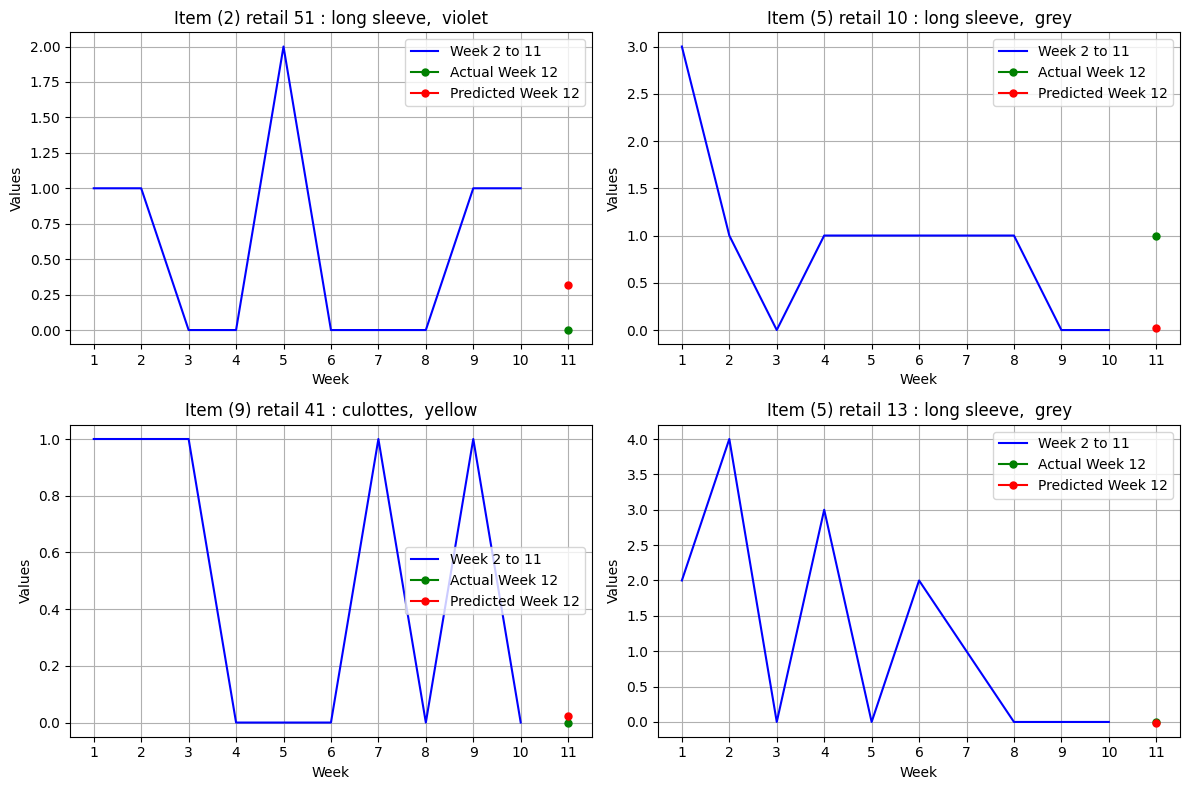

In [ ]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, ax in enumerate(axs.flat, start=1):
    # Plot original data from week 1 to 11 in blue
    ax.plot(range(1, 11), x_test_original[i, 3:13], color='blue', label='Week 2 to 11')

    # Plot actual data for week 12 in green
    ax.plot(11, y_test[i], marker='o', markersize=5, color='green', label='Actual Week 12')

    # Plot predicted data for week 12 in red
    ax.plot(11, y_test_pred[i], marker='o', markersize=5, color='red', label='Predicted Week 12')

    ax.set_xticks(range(1, 12))  # Set the x-axis ticks from 1 to 12
    ax.set_xlabel('Week')
    ax.set_ylabel('Values')
    ax.set_title(f'Item ({sales.external_code[i]}) retail {sales.retail[i]} : {sales.category[i]},  {sales.color[i]}')
    ax.legend()
    # Add a grid to the subplot
    ax.grid(True)

plt.tight_layout()
plt.show()

# Cross Validation

# TimeSeriesSplit aka Walk Forward CV

In [ ]:
# Specify the number of folds for cross-validation
n_splits = 5

tscv = TimeSeriesSplit(n_splits=5)

mae_tscv = []
wape_tscv = []

# Create and compile the Keras model
model = createModel()
model.compile(loss='mse', optimizer='adam')

# Initialize a list to store cross-validation scores
cv_scores = []

# Perform cross-validation
for train_index, test_index in tscv.split(x_train):
    x_train_temp, x_test_temp = x_train[train_index], x_train[test_index]
    y_train_temp, y_test_temp = y_train[train_index], y_train[test_index]

    # Train the model on the training data
    model.fit(x_train_temp, y_train_temp, validation_data=(x_test_temp, y_test_temp), epochs=5, batch_size=128)

    # Evaluate the model on the test data
    y_pred = model.predict(x_test_temp)

    # Calculate Weighted Mean Absolute Percent Error for this fold
    wf_wape = ((mae(y_test_temp, y_pred)*len(y_pred)) / sum(y_test_temp)[0])*100
    #print("Fold WAPE: ", wf_wape)
    wape_tscv.append(wf_wape)

    # Calculate Mean Absolute Error for this fold
    wf_mae = mae(y_test_temp, y_pred)
    #print("Fold MAE: ", wf_mae)
    mae_tscv.append(wf_mae)

WAPE = sum(wape_tscv) / len(wape_tscv)
wape_values.append({"Walk forward CV": WAPE})

MAE = sum(mae_tscv) / len(mae_tscv)
mae_values.append({"Walk forward CV": MAE})

# Calculate and print mean WAPE and MAE across all folds
print('\n\n************ TimeseriesSplit/WalkForward Cross Validation ***************\n')
print("Mean WAPE : ", WAPE)
print("Mean MAE : ",  MAE)

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=18, forecast_length=1, share_thetas=False) at @133303606494832
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=18, forecast_length=1, share_thetas=False) at @133303606494832
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=18, forecast_length=1, share_thetas=False) at @133307044973296
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=18, forecast_length=1, share_thetas=False) at @133307044973296
| --  Stack Seasonality (#2) (share_weights_in_stack=True)
     | -- SeasonalityBlock(units=64, thetas_dim=1, backcast_length=18, forecast_length=1, share_thetas=True) at @133303607835616
     | -- SeasonalityBlock(units=64, thetas_dim=1, backcast_length=18, forecast_length=1, share_thetas=True) at @133303607835616
| --  Stack Trend (#3) (share_weights_in_stack=True)
     |

# Grouped Cross Validation

In [ ]:
def group_time_series_cv(model, X, y, groups, n_splits=2):

    unique_groups = np.unique(groups)
    splits = np.array_split(unique_groups, n_splits+1)
    mse_gcv = []
    mae_gcv = []
    wape_gcv = []

    for i in range(len(splits)-1):
        train_groups = np.concatenate(splits[0:i+1])
        test_groups = splits[i+1]

        train_index = np.isin(groups, train_groups)
        test_index = np.isin(groups, test_groups)

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Print unique values of X[:,12] for each split
        #print("Unique values in train split:", np.unique(X_train[:,-1]))
        #print("Unique values in test split:", np.unique(X_test[:,-1]))

        # Train the model on the training data
        model.fit(X_train, y_train, validation_data=(X_test, y_test),  epochs=3, batch_size=128)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Evaluate performance
        gts_mse = mse(y_test, y_pred)
        mse_gcv.append(gts_mse)

        #Weighted Absolute Percent Error
        gts_wape = ((mae(y_test,y_pred)*int(len(y_pred)) ) / sum(y_test)[0])*100
        wape_gcv.append(gts_wape)
        #print(f"fold {i} gts_wape:",gts_wape)

        gts_mae = mae(y_test, y_pred)
        mae_gcv.append(gts_mae)
        #print(f"fold {i} gts_mae:", gts_mae)

    mse_gcv = np.array(mse_gcv)
    return mse_gcv, model, wape_gcv, mae_gcv

model_gcv = createModel()
model_gcv.compile(loss='mse', optimizer='adam')

groups = x_train[:,-1] #choose Last column(encoded release date)
#print('group_size:',groups.shape)

mse_gcv, model, wape_gcv, mae_gcv = group_time_series_cv(model_gcv, x_train, y_train, groups, n_splits=5)

WAPE = sum(wape_gcv) / len(wape_gcv)
wape_values.append({"Group CV": WAPE})

MAE = sum(mae_gcv)/len(mae_gcv)
mae_values.append({"Group CV": MAE})

print('\n\n************ Group Timeseries Cross Validation ***************\n')
print("Mean Squared Error:", mse_gcv.mean())
print("Mean WAPE", WAPE)
print("Mean MAE:", MAE)

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=18, forecast_length=1, share_thetas=False) at @133303571935296
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=18, forecast_length=1, share_thetas=False) at @133303571935296
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=18, forecast_length=1, share_thetas=False) at @133303571935008
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=18, forecast_length=1, share_thetas=False) at @133303571935008
| --  Stack Seasonality (#2) (share_weights_in_stack=True)
     | -- SeasonalityBlock(units=64, thetas_dim=1, backcast_length=18, forecast_length=1, share_thetas=True) at @133303571934576
     | -- SeasonalityBlock(units=64, thetas_dim=1, backcast_length=18, forecast_length=1, share_thetas=True) at @133303571934576
| --  Stack Trend (#3) (share_weights_in_stack=True)
     |

#Purged Group CV

In [ ]:
def purged_group_time_series_cv_iterative(X, y, groups, n_splits = 5, group_gap = 1 ):

    model = createModel()
    model.compile(loss='mse', optimizer='adam')

    mse_scores = []
    mae_pgcv = []
    wape_pgcv = []


    unique_groups = np.unique(groups)
    splits = np.array_split(unique_groups, n_splits+1)


    for i in range(len(splits)-1):
        train_groups = splits[i].ravel()
        #print('train:',train_groups)
        test_groups = splits[i+1].ravel()
        #print('test:',test_groups)

        train_groups = train_groups[:-group_gap]
        test_groups = test_groups[group_gap:]

        train_index = np.isin(groups, train_groups)
        test_index = np.isin(groups, test_groups)

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Print unique values of X[:,12] for each split
        #print("Unique values in train split:", np.unique(X_train[:,-1]))
        #print("Unique values in test split:", np.unique(X_test[:,-1]))

        # Train the model
        model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=5)

        # Make predictions on the validation set
        y_pred = model.predict(X_test)

        # Evaluate performance
        mse_pgcv = mse(y_test, y_pred)

        mse_scores.append(mse_pgcv)

        mae_fold = mae(y_test, y_pred)
        mae_pgcv.append(mae_fold)
        #print(f"fold {i} pgcv_mae:", mae_pgcv)

        #Weighted Absolute Percent Error
        wape_fold = ((mae(y_test,y_pred)*int(len(y_pred)) ) / sum(y_test)[0])*100
        wape_pgcv.append(wape_fold)
        #print(f"fold {i} pgcv_wape:",wape_fold)


    mse_scores = np.array(mse_scores)
    return mse_scores, model, mae_pgcv, wape_pgcv

groups = x_train[:,-1] #choose Last week

# Set the number of splits for cross-validation
n_splits = 5

# Set the group gap
group_gap = 1

# Perform Iterative Purged Group Time Series Cross-Validation
mse_scores, model, mae_pgcv, wape_pgcv = purged_group_time_series_cv_iterative(x_train, y_train, groups, n_splits=n_splits, group_gap=group_gap)

WAPE = sum(wape_pgcv) / len(wape_pgcv)
wape_values.append({"Purged Group CV": WAPE})

MAE = sum(mae_pgcv)/len(mae_pgcv)
mae_values.append({"Purged Group CV": MAE})

print('\n\n************ Purged Group Cross Validation ***************\n')
print("Mean Squared Error", mse_scores.mean())
print("Mean WAPE", WAPE)
print("Mean MAE:", MAE)

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=18, forecast_length=1, share_thetas=False) at @133303571657728
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=18, forecast_length=1, share_thetas=False) at @133303571657728
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=18, forecast_length=1, share_thetas=False) at @133303571659552
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=18, forecast_length=1, share_thetas=False) at @133303571659552
| --  Stack Seasonality (#2) (share_weights_in_stack=True)
     | -- SeasonalityBlock(units=64, thetas_dim=1, backcast_length=18, forecast_length=1, share_thetas=True) at @133303571658160
     | -- SeasonalityBlock(units=64, thetas_dim=1, backcast_length=18, forecast_length=1, share_thetas=True) at @133303571658160
| --  Stack Trend (#3) (share_weights_in_stack=True)
     |

# Combinatorial Purged Group CV

In [ ]:
def purge_and_embargo(arr,start = 0, end =  161):
  arr = np.sort(arr)
  indices = np.where(np.diff(arr) != 1)[0]
  new_arr = np.delete(arr, np.concatenate([indices, indices+1]))
  if new_arr[0] != start:
    new_arr = np.delete(new_arr, 0)
  if new_arr[-1] != end:
    new_arr = np.delete(new_arr, -1)
  return new_arr

In [ ]:
def combinatorial_group_time_series_cv(model, X, y, groups, n_splits=6, test_set = 2):
    unique_groups = np.unique(groups)
    splits = np.array_split(unique_groups, n_splits)
    mse_scores = []
    mae_cpcv = []
    wape_cpcv = []

    test_splits = list(combinations(splits, 2))

    for i, test_groups in enumerate(test_splits):
        train_groups = [split for split in splits if all(split is not t for t in test_groups)]
        #train_test.append([train, list(test)])

        test_groups = np.concatenate(test_groups)
        train_groups = np.concatenate(train_groups)

        train_groups = purge_and_embargo(train_groups)
        test_groups = purge_and_embargo(test_groups)

        train_index = np.isin(groups, train_groups)
        test_index = np.isin(groups, test_groups)

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Print unique values of X[:,12] for each split
        #print("Unique values in train split:", np.unique(X_train[:,-1]))
        #print("Unique values in test split:", np.unique(X_test[:,-1]))

        # Train the model
        model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=5)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Evaluate performance
        mse_cpcv = mse(y_test, y_pred)
        mse_scores.append(mse_cpcv)

        #Weighted Absolute Percent Error
        wape_fold = ((mae(y_test,y_pred)*int(len(y_pred)) ) / sum(y_test)[0])*100
        wape_cpcv.append(wape_fold)
        #print(f"split {i} cpcv_wape:",cpcv_wape)


        mae_fold = mae(y_test, y_pred)
        mae_cpcv.append(mae_fold)
        #print(f"split {i} cpcv_mae:", cpcv_mae)

    mse_scores = np.array(mse_scores)
    return mse_scores, model, wape_cpcv, mae_cpcv

groups = x_train[:,-1] #choose Last column(encoded release date)
#print('group_size:',groups.shape)

# Initialize the model
model_cpcv = createModel()
model_cpcv.compile(loss='mse', optimizer='adam')

mse_scores, model, wape_cpcv, mae_cpcv = combinatorial_group_time_series_cv(model_cpcv, x_train, y_train, groups, n_splits=6, test_set=2)

WAPE = sum(wape_cpcv) / len(wape_cpcv)
wape_values.append({"Combinatorial Purged Group CV": WAPE})

MAE = sum(mae_cpcv)/len(mae_cpcv)
mae_values.append({"Combinatorial Purged Group CV": MAE})

print('\n\n************ Combinatorial Purged Group Cross Validation ***************\n')
print("Mean Squared Error:", mse_scores.mean())
print("Mean WAPE", WAPE)
print("Mean MAE", MAE)

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=18, forecast_length=1, share_thetas=False) at @133303571926896
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=18, forecast_length=1, share_thetas=False) at @133303571926896
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=18, forecast_length=1, share_thetas=False) at @133303571926128
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=18, forecast_length=1, share_thetas=False) at @133303571926128
| --  Stack Seasonality (#2) (share_weights_in_stack=True)
     | -- SeasonalityBlock(units=64, thetas_dim=1, backcast_length=18, forecast_length=1, share_thetas=True) at @133303571924064
     | -- SeasonalityBlock(units=64, thetas_dim=1, backcast_length=18, forecast_length=1, share_thetas=True) at @133303571924064
| --  Stack Trend (#3) (share_weights_in_stack=True)
     |

## **Compare WAPE Results**


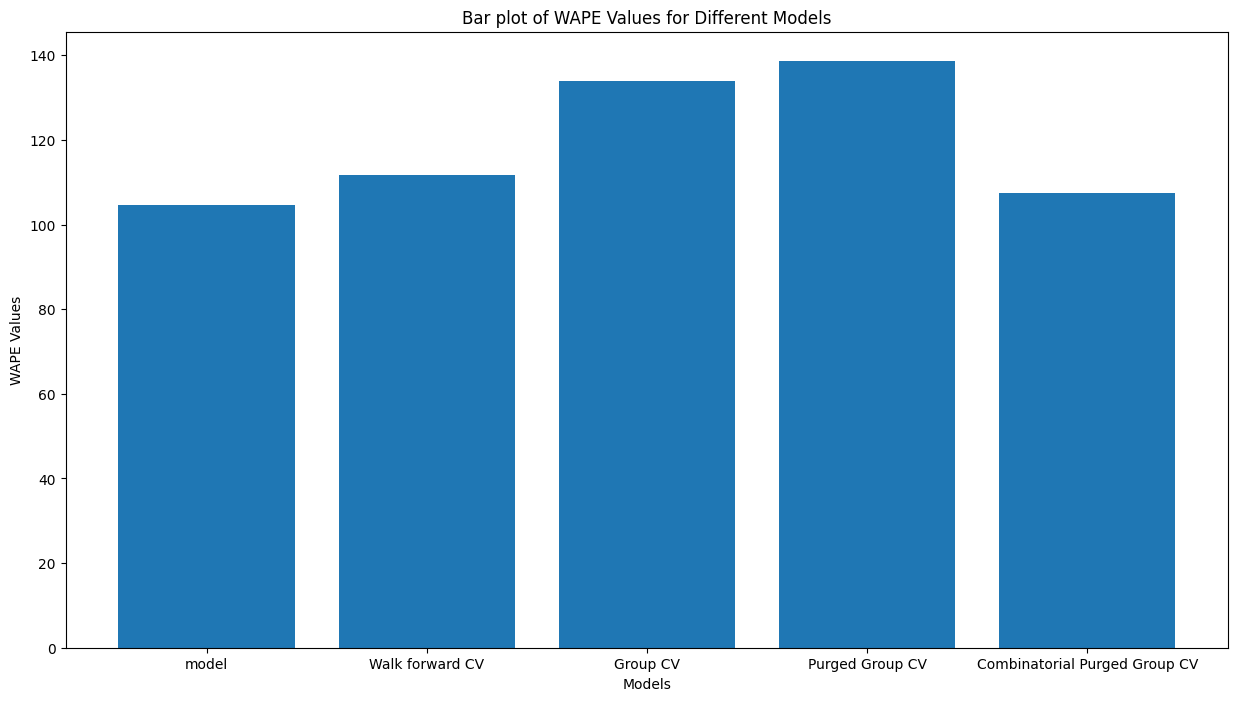

In [ ]:
models = [list(item.keys())[0] for item in wape_values]
values = [list(item.values())[0] for item in wape_values]

# Create the bar plot
plt.figure(figsize=(15, 8))

plt.bar(models, values)
plt.xlabel('Models')
plt.ylabel('WAPE Values')
plt.title('Bar plot of WAPE Values for Different Models')
plt.show()

## **Compare MAE**

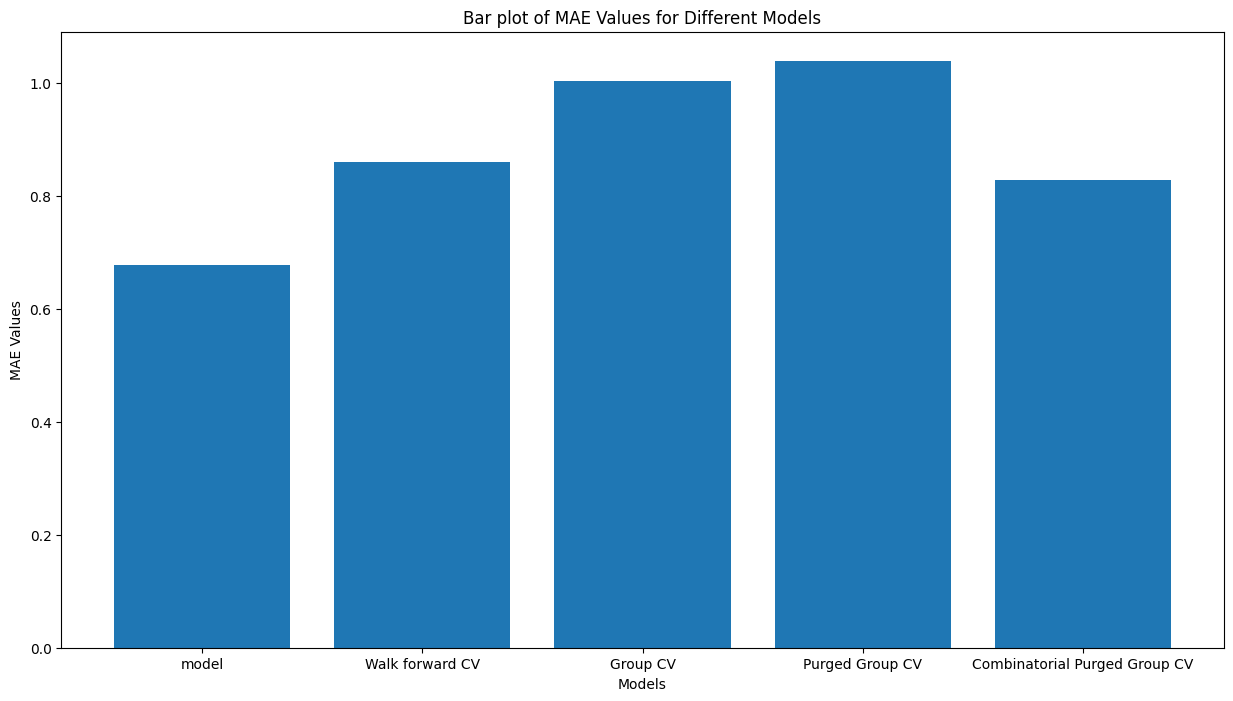

In [ ]:
models = [list(item.keys())[0] for item in mae_values]
values = [list(item.values())[0] for item in mae_values]

# Create the bar plot
plt.figure(figsize=(15, 8))

plt.bar(models, values)
plt.xlabel('Models')
plt.ylabel('MAE Values')
plt.title('Bar plot of MAE Values for Different Models')
plt.show()

In [ ]:
print("WAPE")
display(wape_values)

print("\n\n=============================\n\n")

print("MAE")
display(mae_values)

WAPE


[{'model': 104.55349087525718},
 {'Walk forward CV': 111.74610232740581},
 {'Group CV': 133.91663495009084},
 {'Purged Group CV': 138.63439357804657},
 {'Combinatorial Purged Group CV': 107.39725851334201}]





MAE


[{'model': 0.6783207388352437},
 {'Walk forward CV': 0.861238373827477},
 {'Group CV': 1.0048116606648372},
 {'Purged Group CV': 1.039564304668382},
 {'Combinatorial Purged Group CV': 0.8295416792703477}]